<a href="https://colab.research.google.com/github/kaiketsu927/Deep-Learning/blob/final/Final(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/META.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013/6/10,24.059999,24.600000,23.990000,24.330000,24.330000,58393000
1,2013/6/11,24.030001,24.350000,24.000000,24.030001,24.030001,29885900
2,2013/6/12,24.160000,24.260000,23.580000,23.770000,23.770000,26445800
3,2013/6/13,23.719999,23.830000,23.270000,23.730000,23.730000,31189300
4,2013/6/14,23.559999,23.889999,23.260000,23.629999,23.629999,30677100
...,...,...,...,...,...,...,...
2514,2023/6/5,270.299988,275.570007,269.559998,271.390015,271.390015,20742900
2515,2023/6/6,270.140015,276.570007,269.690002,271.119995,271.119995,19419000
2516,2023/6/7,271.670013,274.250000,262.799988,263.600006,263.600006,26163600
2517,2023/6/8,260.619995,267.649994,258.880005,264.579987,264.579987,20899400


In [5]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2519 non-null   object 
 1   Open       2519 non-null   float64
 2   High       2519 non-null   float64
 3   Low        2519 non-null   float64
 4   Close      2519 non-null   float64
 5   Adj Close  2519 non-null   float64
 6   Volume     2519 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.9+ KB


In [6]:
new_df=df.iloc[:,[0,4]].copy()
new_df.head()

,Date,Close
0,2013/6/10,24.330000
1,2013/6/11,24.030001
2,2013/6/12,23.770000
3,2013/6/13,23.730000
4,2013/6/14,23.629999


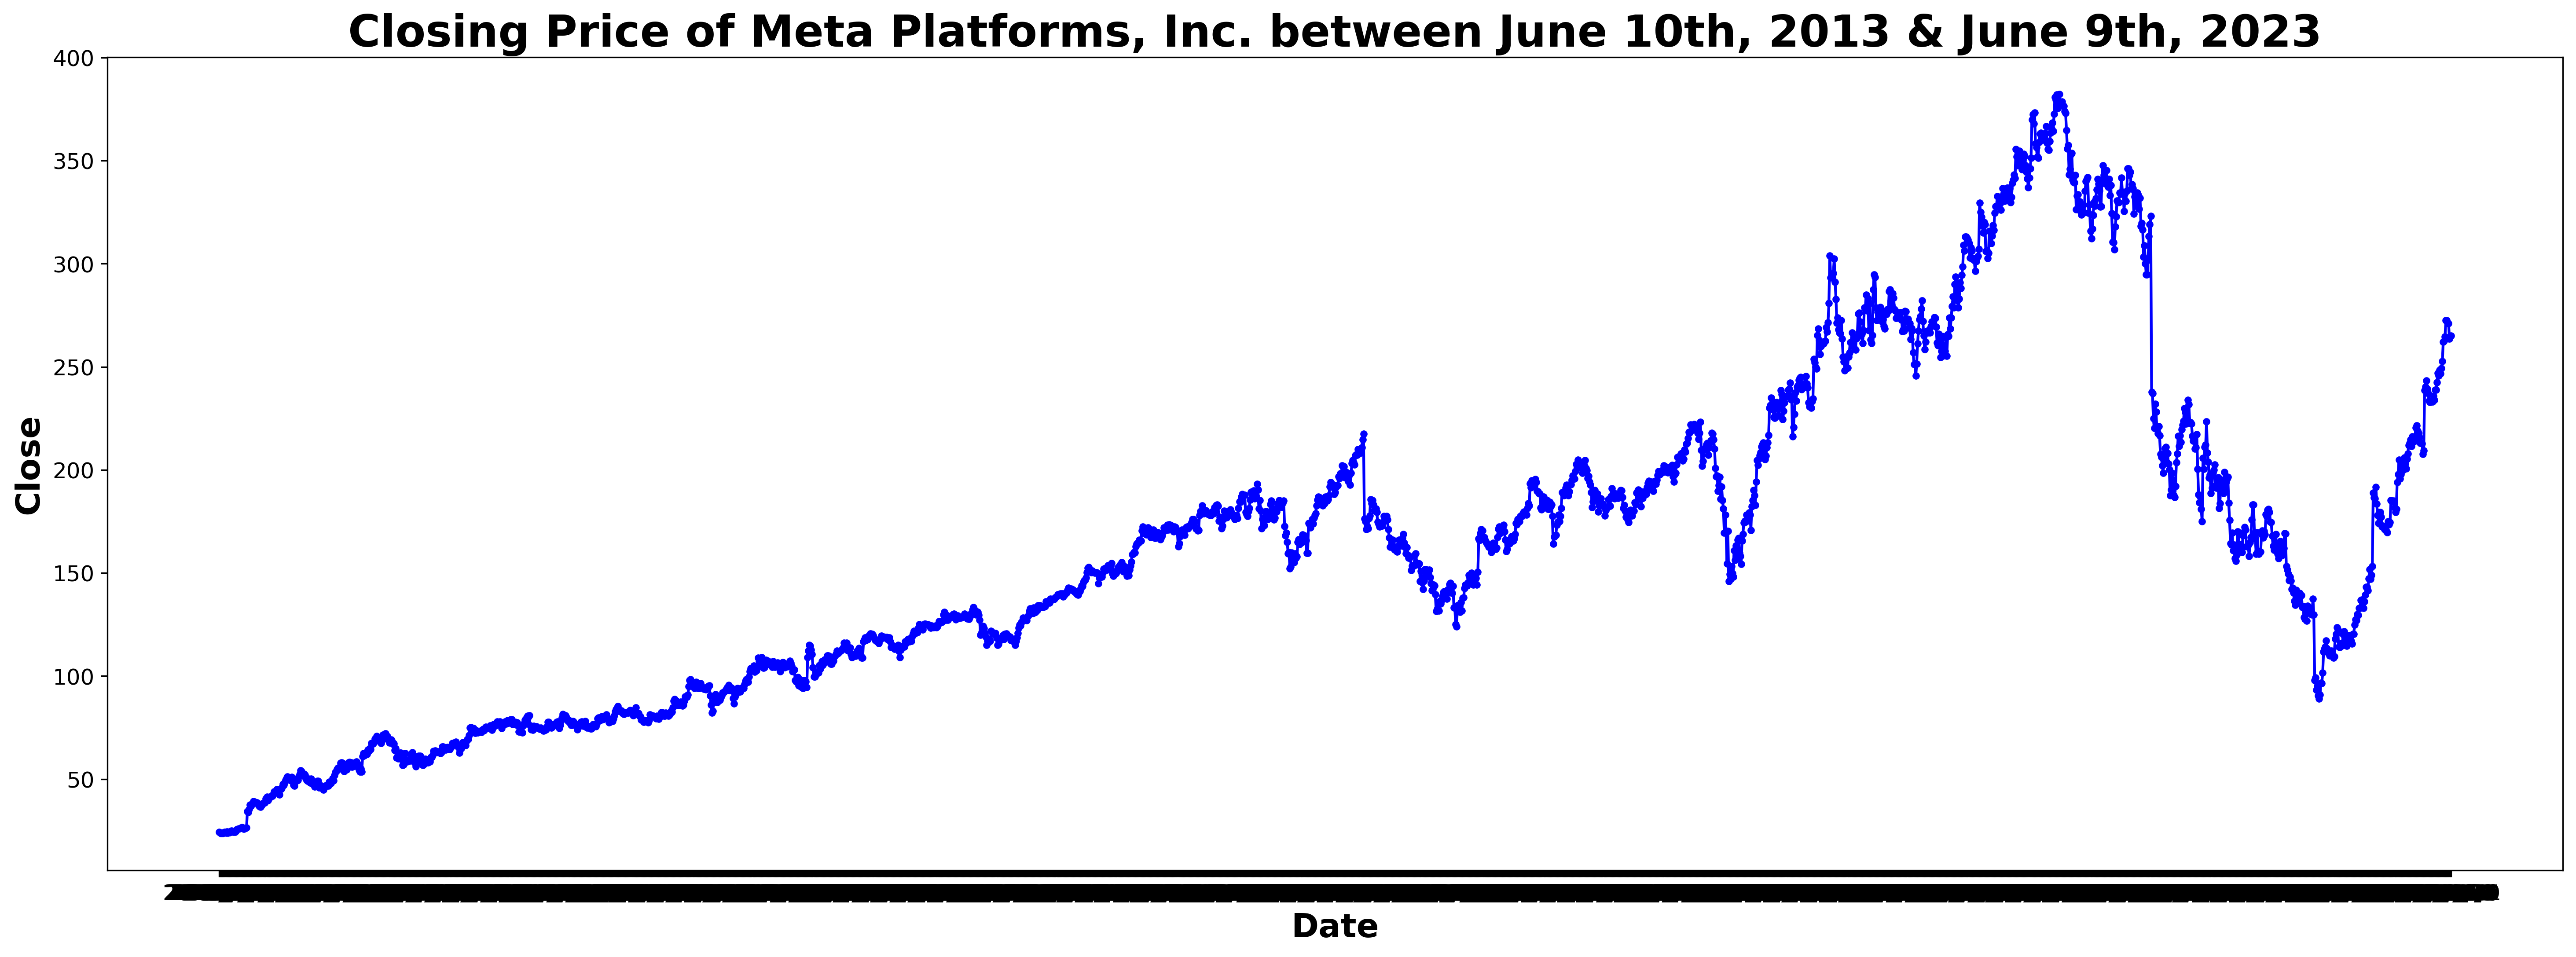

In [7]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Closing Price of Meta Platforms, Inc. between June 10th, 2013 & June 9th, 2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Close'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#  Creating time lags as predictor variables
Important!: Be caution when dealing with time-series data

In [8]:
# Create 3 lags
new_df['Lag_1']=new_df['Close'].shift(1).copy()
new_df['Lag_2']=new_df['Close'].shift(2).copy()
new_df['Lag_3']=new_df['Close'].shift(3).copy()
new_df.head()

,Date,Close,Lag_1,Lag_2,Lag_3
0,2013/6/10,24.330000,NaN,NaN,NaN
1,2013/6/11,24.030001,24.330000,NaN,NaN
2,2013/6/12,23.770000,24.030001,24.330000,NaN
3,2013/6/13,23.730000,23.770000,24.030001,24.330000
4,2013/6/14,23.629999,23.730000,23.770000,24.030001


In [9]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Close,Lag_1,Lag_2,Lag_3
0,2013/6/13,23.730000,23.770000,24.030001,24.330000
1,2013/6/14,23.629999,23.730000,23.770000,24.030001
2,2013/6/17,24.020000,23.629999,23.730000,23.770000
3,2013/6/18,24.209999,24.020000,23.629999,23.730000
4,2013/6/19,24.309999,24.209999,24.020000,23.629999
...,...,...,...,...,...
2511,2023/6/5,271.390015,272.609985,272.609985,264.720001
2512,2023/6/6,271.119995,271.390015,272.609985,272.609985
2513,2023/6/7,263.600006,271.119995,271.390015,272.609985
2514,2023/6/8,264.579987,263.600006,271.119995,271.390015


In [10]:
# Colab
clean_df.to_csv('Meta_Lags.csv',index=False, header=True)

# **Data preprocessing under time-series structure**

In [11]:
# Train data
Forecast_train_data=clean_df.iloc[0:2013,:].copy()
Forecast_train_data

,Date,Close,Lag_1,Lag_2,Lag_3
0,2013/6/13,23.730000,23.770000,24.030001,24.330000
1,2013/6/14,23.629999,23.730000,23.770000,24.030001
2,2013/6/17,24.020000,23.629999,23.730000,23.770000
3,2013/6/18,24.209999,24.020000,23.629999,23.730000
4,2013/6/19,24.309999,24.209999,24.020000,23.629999
...,...,...,...,...,...
2008,2021/6/4,330.350006,326.040009,329.149994,329.130005
2009,2021/6/7,336.579987,330.350006,326.040009,329.149994
2010,2021/6/8,333.679993,336.579987,330.350006,326.040009
2011,2021/6/9,330.250000,333.679993,336.579987,330.350006


In [12]:
# Test data
Forecast_test_data=clean_df.iloc[2013:,:].copy()
Forecast_test_data

,Date,Close,Lag_1,Lag_2,Lag_3
2013,2021/6/11,331.260010,332.459991,330.250000,333.679993
2014,2021/6/14,336.769989,331.260010,332.459991,330.250000
2015,2021/6/15,336.750000,336.769989,331.260010,332.459991
2016,2021/6/16,331.079987,336.750000,336.769989,331.260010
2017,2021/6/17,336.510010,331.079987,336.750000,336.769989
...,...,...,...,...,...
2511,2023/6/5,271.390015,272.609985,272.609985,264.720001
2512,2023/6/6,271.119995,271.390015,272.609985,272.609985
2513,2023/6/7,263.600006,271.119995,271.390015,272.609985
2514,2023/6/8,264.579987,263.600006,271.119995,271.390015


# **Prepare time-series data for train/validation structure manually**

**Expending Window**

In [13]:
# Expanding 1
Exp_training_1=Forecast_train_data.iloc[0:1257,:].copy()
Exp_val_1=Forecast_train_data.iloc[1257:1257+252,:].copy()

# Expanding 2
Exp_training_2=Forecast_train_data.iloc[0:1509,:].copy()
Exp_val_2=Forecast_train_data.iloc[1509:1509+252,:].copy()

# Expanding 3
Exp_training_3=Forecast_train_data.iloc[0:1761,:].copy()
Exp_val_3=Forecast_train_data.iloc[1761:1761+252,:].copy()

**Rolling Window**

In [14]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:1257,:].copy()
Rol_val_1=Forecast_train_data.iloc[1257:1257+252,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[249:1509,:].copy()
Rol_val_2=Forecast_train_data.iloc[1509:1509+252,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[501:1761,:].copy()
Rol_val_3=Forecast_train_data.iloc[1761:1761+252,:].copy()

# **Set dependent variable(Y or target) & independent variable(X)**

In [15]:
# (Expending)
#set x (make prediction)
# Train
x_train=Exp_training_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Exp_val_3.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Exp_training_3['Close'].copy()
y_val=Exp_val_3['Close'].copy()

In [16]:
#(Rolling)
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Close'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Close'].copy()
y_val=Rol_val_1['Close'].copy()

# **6. Creating Net**

In [17]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.000822,0.002348,0.004109
1,0.000587,0.000822,0.002348
2,0.000000,0.000587,0.000822
3,0.002289,0.000000,0.000587
4,0.003405,0.002289,0.000000


In [18]:
# Tips: Using shape to call the amount of features in the data set
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# **Important: Define customized loss function (RMSE)**

In [19]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

In [21]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

# **Sequential style coding for creating net**

In [22]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# Add fourth hidden layer
model.add(Dense(units=48, activation='linear'))

# Add 2 more dense layers
dense_generator(model,2,192)

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.001,beta_1=0.95)
model.compile(loss='my_RMSE', optimizer=opt,
metrics=['mean_absolute_percentage_error'])

# Finally check the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 384)               18816     
                                                                 
 dense_5 (Dense)             (None, 768)               295680    
                                                                 
 dense_6 (Dense)             (None, 1)                 7

# **Fit the model (train/validation)**

In [23]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=200, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/200
20/20 [==============================] - 2s 23ms/step - loss: 101.7888 - mean_absolute_percentage_error: 95.4948 - val_loss: 149.8859 - val_mean_absolute_percentage_error: 89.6358
Epoch 2/200
20/20 [==============================] - 0s 10ms/step - loss: 48.3483 - mean_absolute_percentage_error: 45.3055 - val_loss: 34.3183 - val_mean_absolute_percentage_error: 22.1090
Epoch 3/200
20/20 [==============================] - 0s 10ms/step - loss: 16.9589 - mean_absolute_percentage_error: 16.6673 - val_loss: 72.4407 - val_mean_absolute_percentage_error: 44.4790
Epoch 4/200
20/20 [==============================] - 0s 10ms/step - loss: 8.1925 - mean_absolute_percentage_error: 9.0506 - val_loss: 71.8693 - val_mean_absolute_percentage_error: 44.2148
Epoch 5/200
20/20 [==============================] - 0s 9ms/step - loss: 4.8578 - mean_absolute_percentage_error: 5.2118 - val_loss: 66.0971 - val_mean_absolute_percentage_error: 40.9562
Epoch 6/200
20/20 [==============================] - 

In [25]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

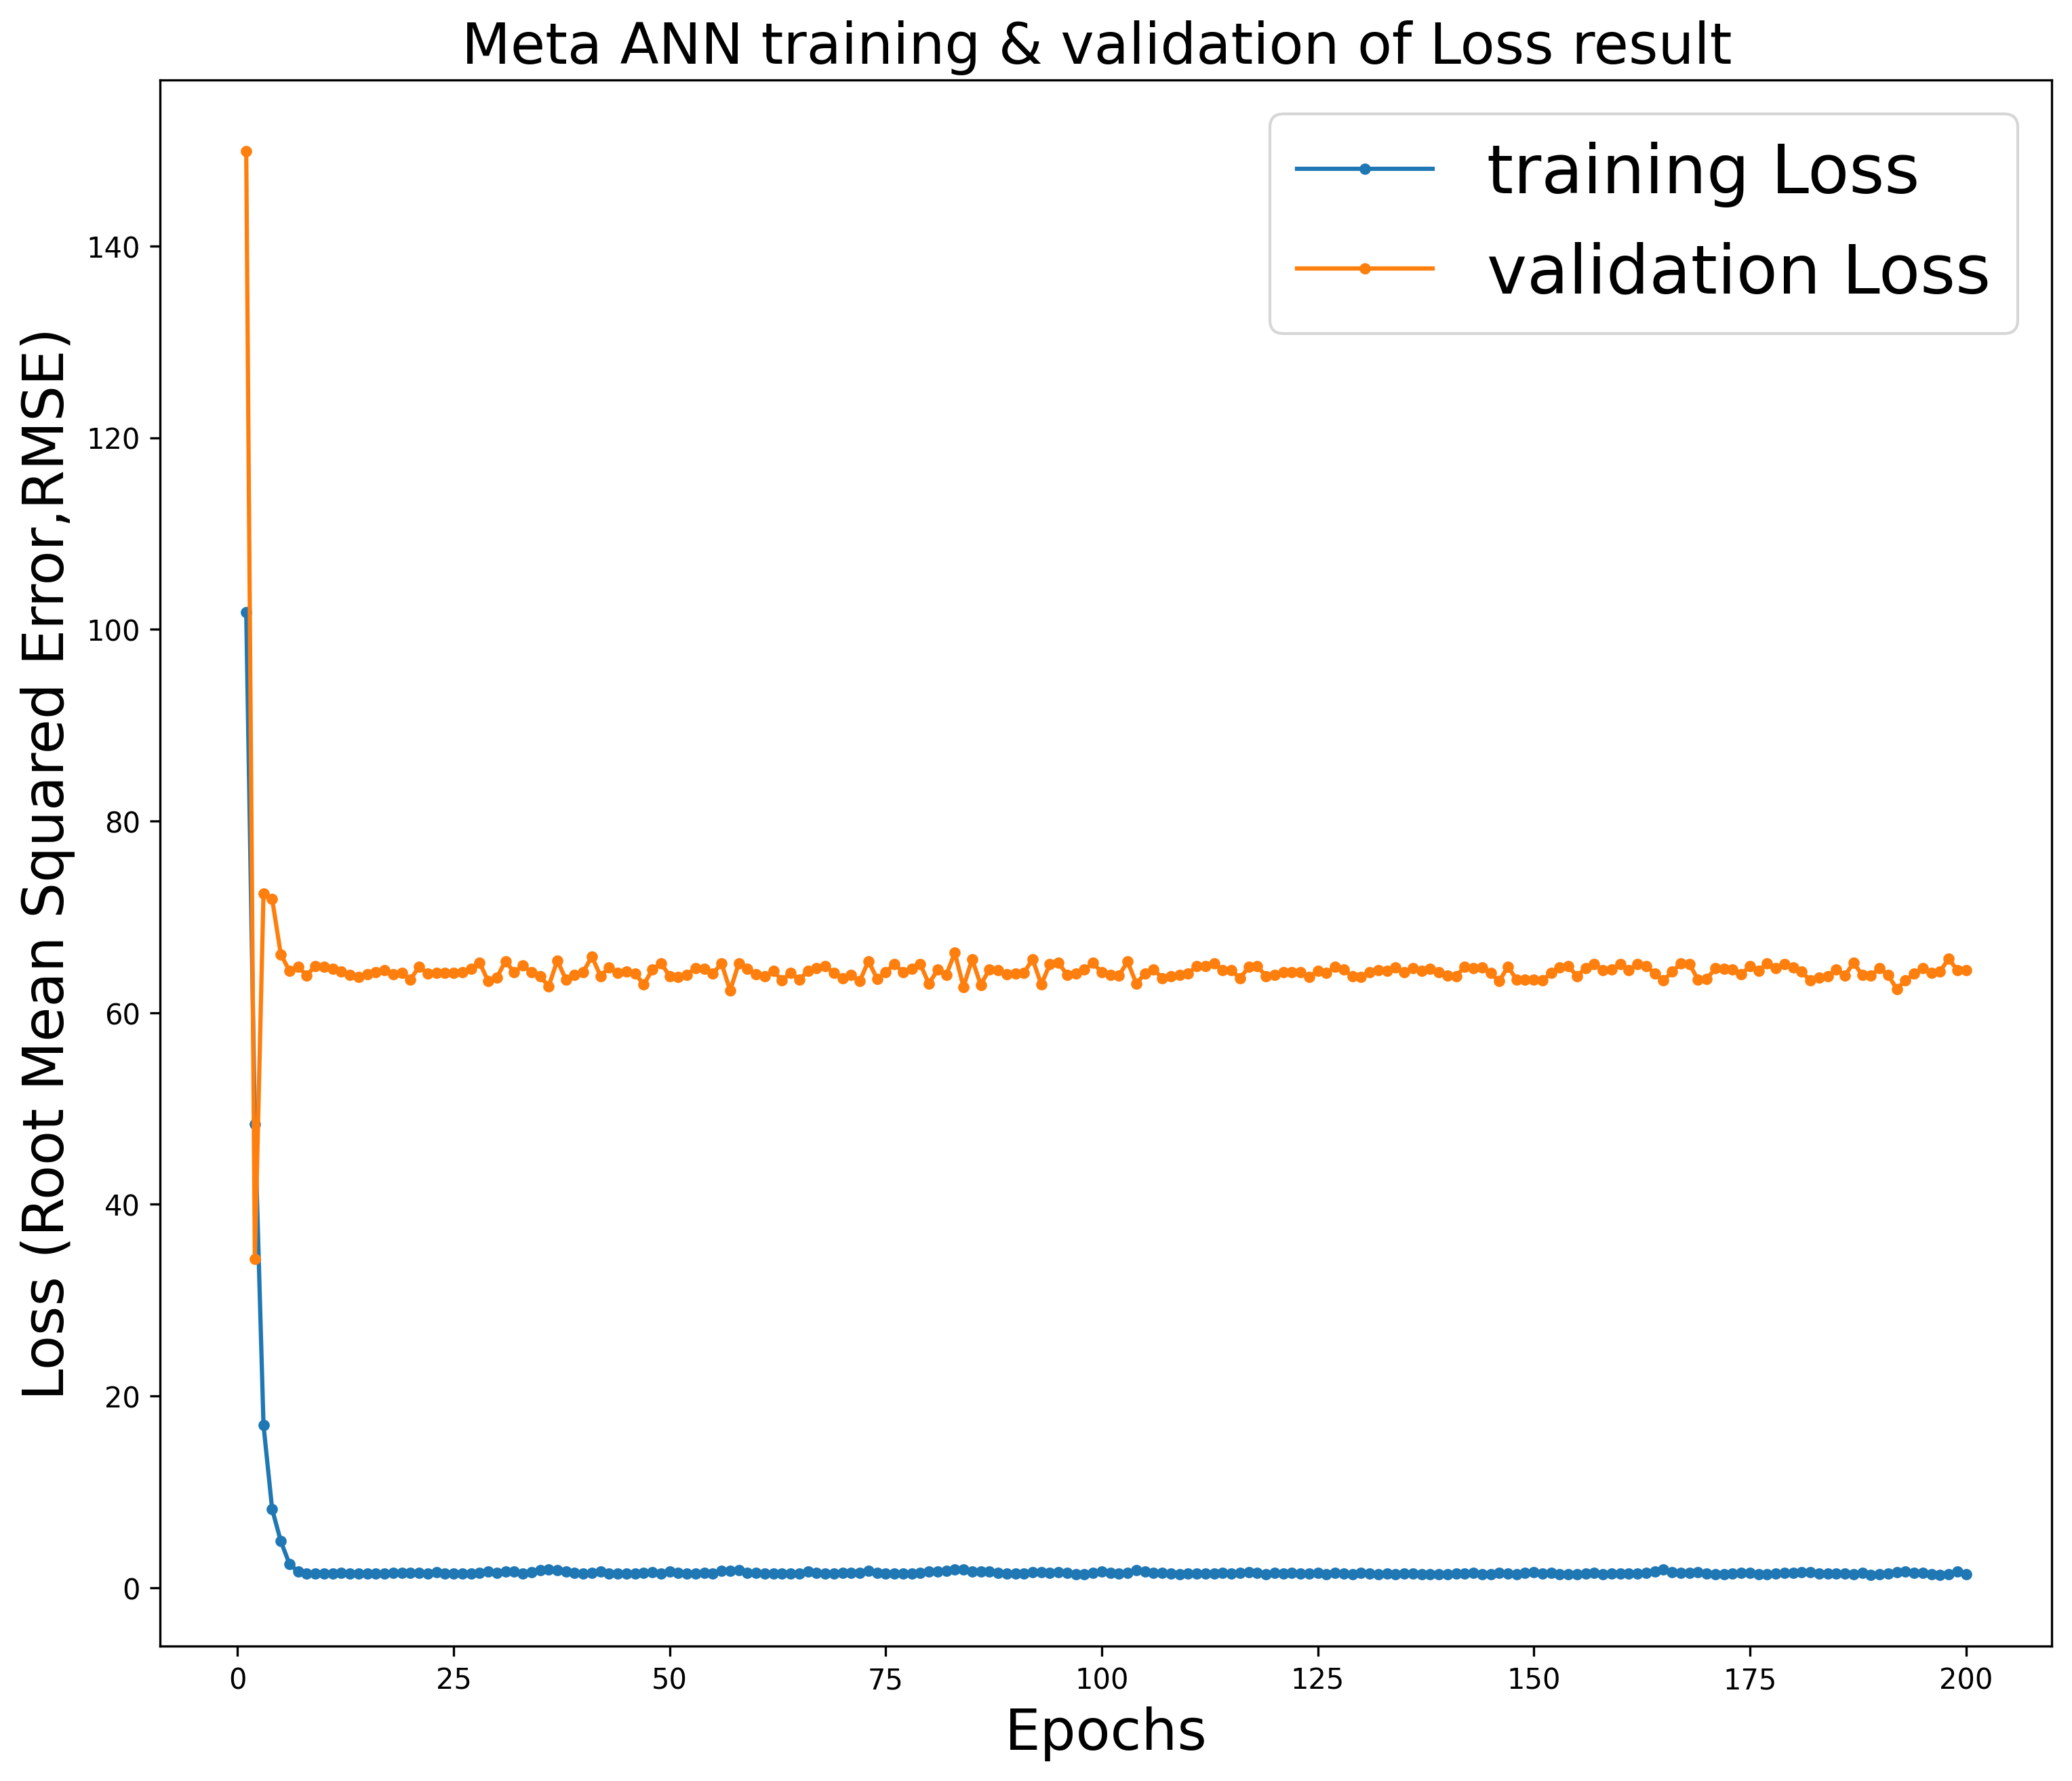

In [26]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('Meta ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

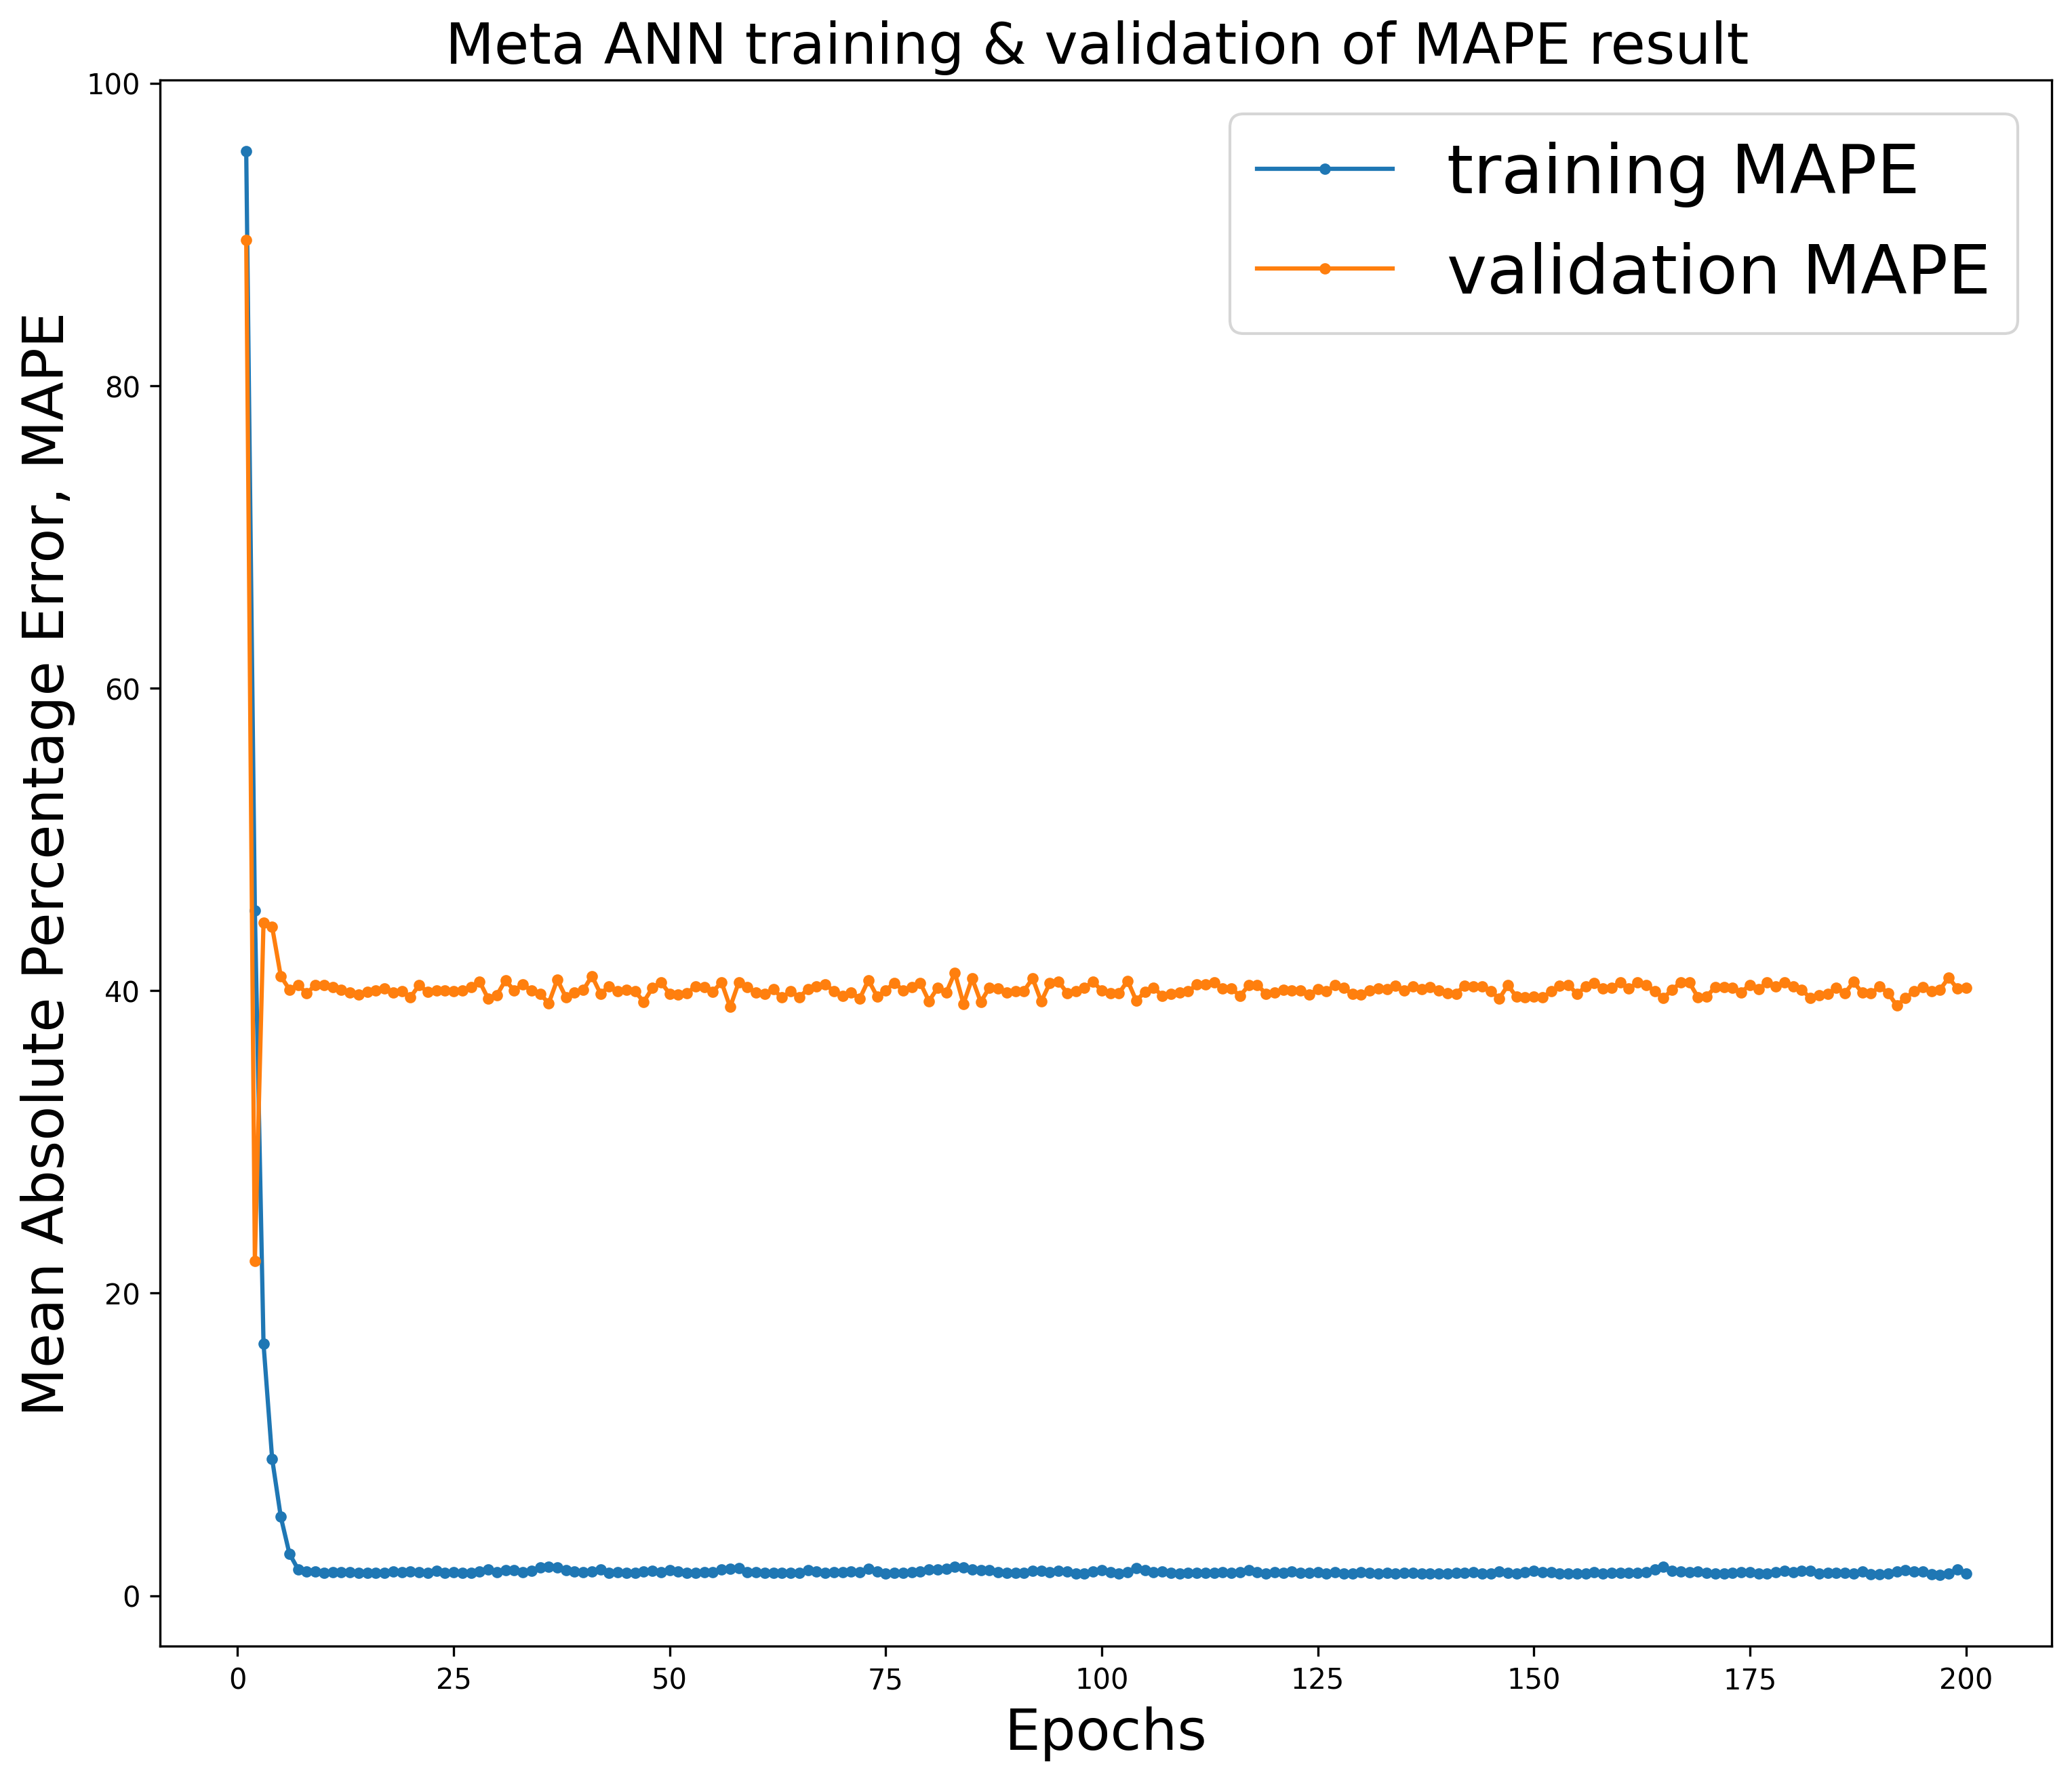

In [27]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('Meta ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# **Fit the final model with all of the training data**

In [28]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Close'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Close'].copy()

In [29]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add fourth hidden layer
Fmodel.add(Dense(units=48, activation='linear'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
opt=Adam(learning_rate=0.01,beta_1=0.8)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,669
Trainable params: 1,669
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=200, batch_size=64,verbose=1)

Epoch 1/200
32/32 [==============================] - 1s 3ms/step - loss: 21.9744 - mean_absolute_percentage_error: 15.1509
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 6.7517 - mean_absolute_percentage_error: 4.6458
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 5.6694 - mean_absolute_percentage_error: 3.8410
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 4.7864 - mean_absolute_percentage_error: 3.2299
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 5.1883 - mean_absolute_percentage_error: 3.5438
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 6.2488 - mean_absolute_percentage_error: 4.2647
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 4.7011 - mean_absolute_percentage_error: 3.2197
Epoch 8/200
32/32 [==============================] - 0s 3ms/step - loss: 4.7688 - mean_absolute_percentage_error: 3.2608
Epoch 9/200
32/32 [===========

In [31]:
# Colab
Fmodel.save('Meta_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [32]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('Meta_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# **Testing**

In [33]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Close'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Close'].copy()
# 8.1 Make prediction
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Close_true':Forecast_test_data['Close'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Close_true']-Results['Predict'])
Results

,Date,Close_true,Predict,abs Error
2013,2021/6/11,331.260010,331.540009,0.279999
2014,2021/6/14,336.769989,330.750000,6.019989
2015,2021/6/15,336.750000,335.299988,1.450012
2016,2021/6/16,331.079987,335.980011,4.900024
2017,2021/6/17,336.510010,331.290009,5.220001
...,...,...,...,...
2511,2023/6/5,271.390015,271.940002,0.549987
2512,2023/6/6,271.119995,271.070007,0.049988
2513,2023/6/7,263.600006,270.679993,7.079987
2514,2023/6/8,264.579987,264.260010,0.319977


In [34]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 4.644
MSE: 53.049
RMSE: 7.283
MAPE: 2.224 %
SMAPE: 2.212 %
RAE: 0.062
MRAE: 0.00012372317450408128
MdRAE: 0.048 bench: 231.013
RSE: 0.007
RRSE: 0.086


# **Plot for comparing true value & predicted value**

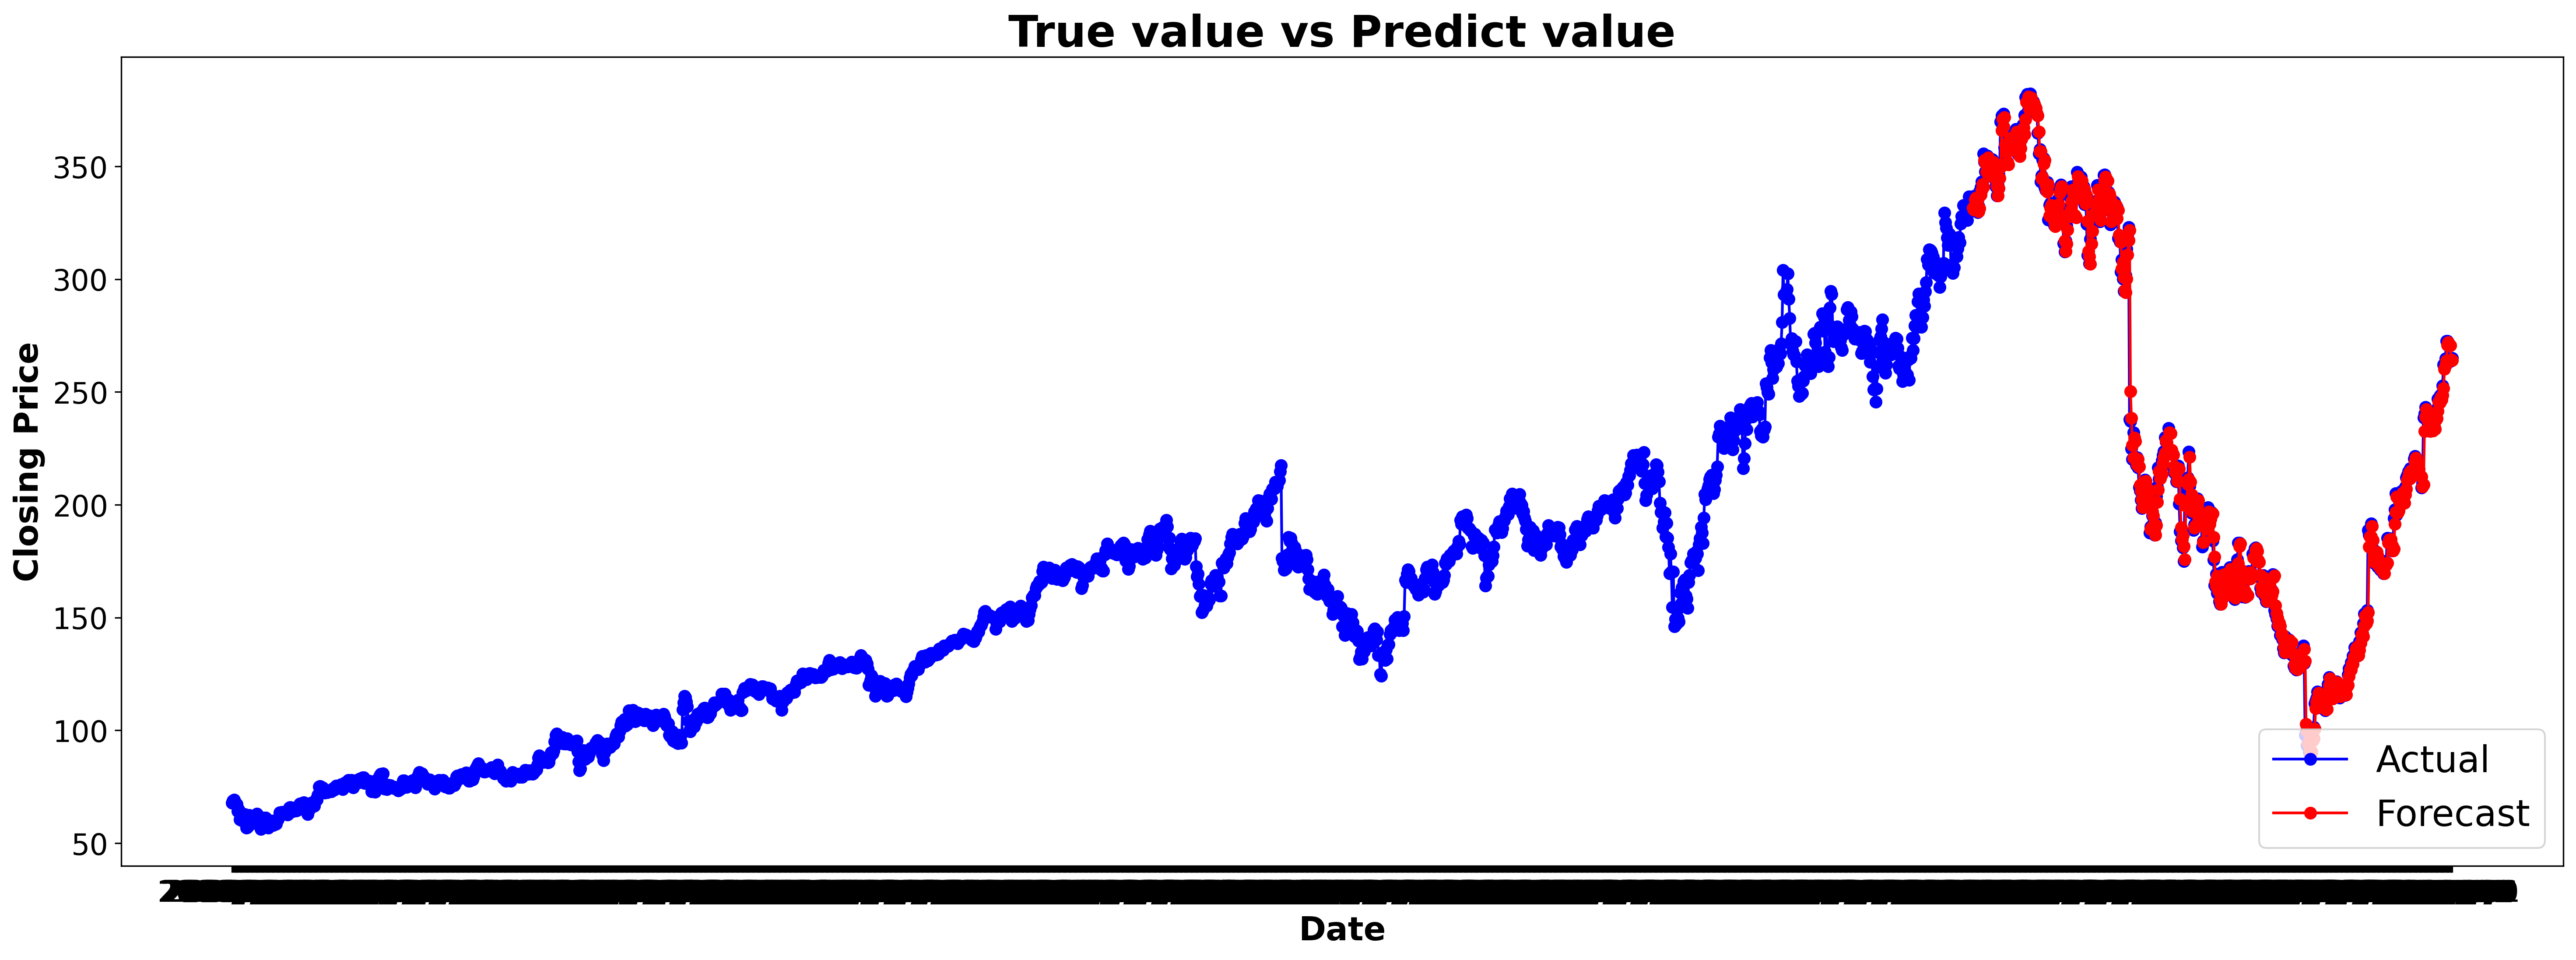

In [35]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('True value vs Predict value',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Closing Price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

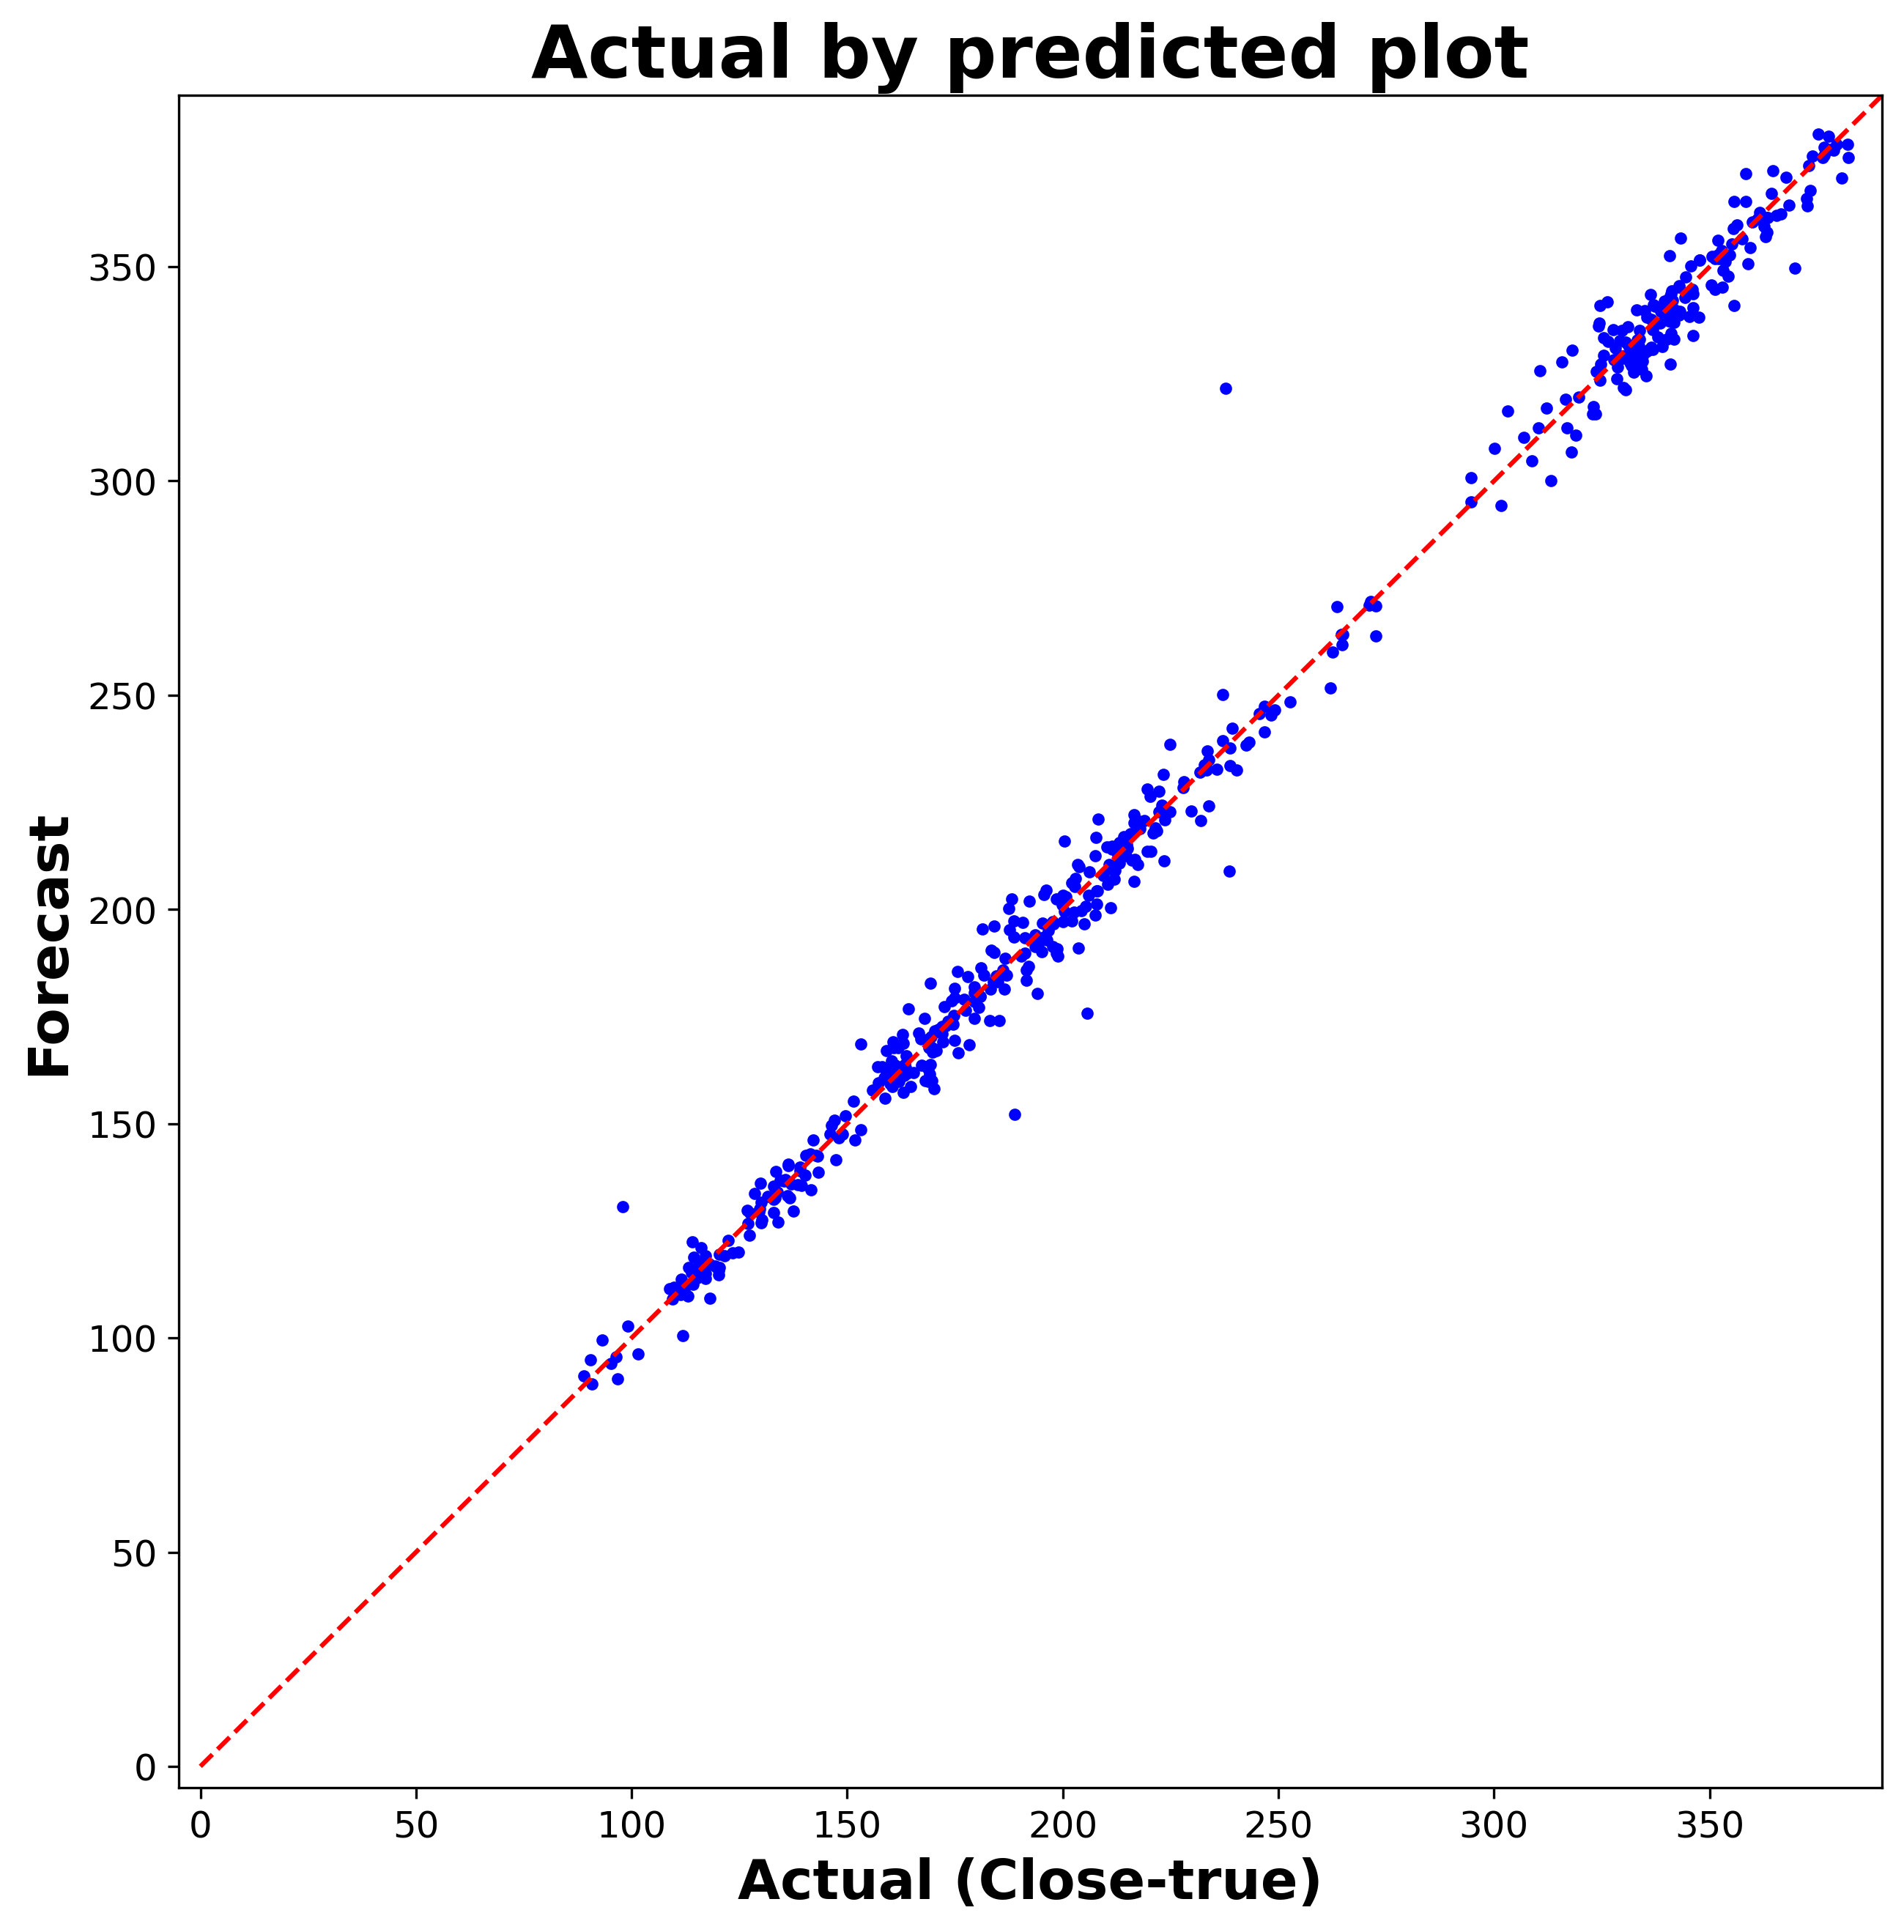

In [36]:
# Lock the scale of axis by Close_true
max_value=390
min_value=0

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Close-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()